В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Accuracy: 87.37%
F1 score Train: 0.63%
Accuracy: 87.13%
F1 score Validation: 0.64%


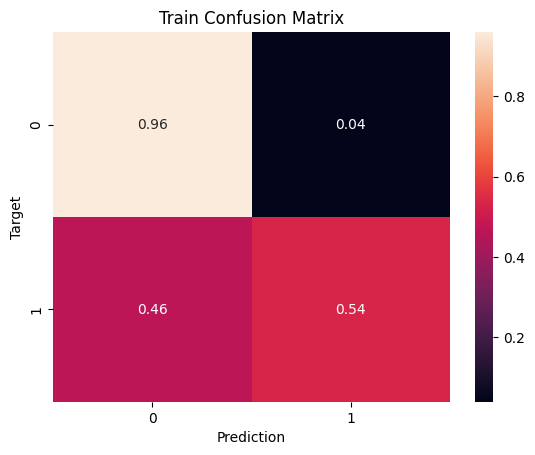

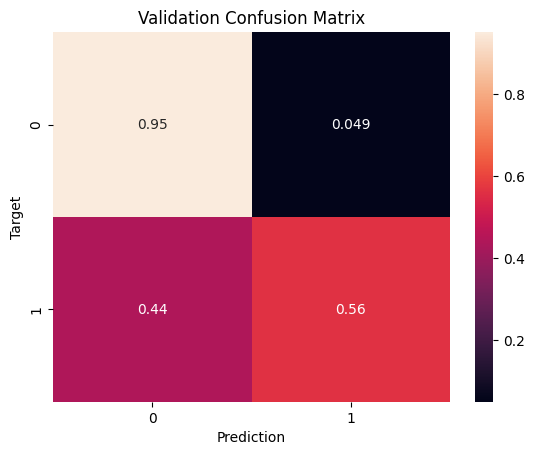

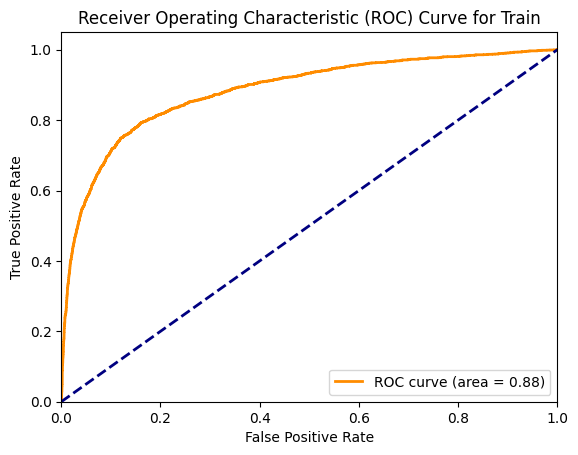

AUROC for Train: 0.8822


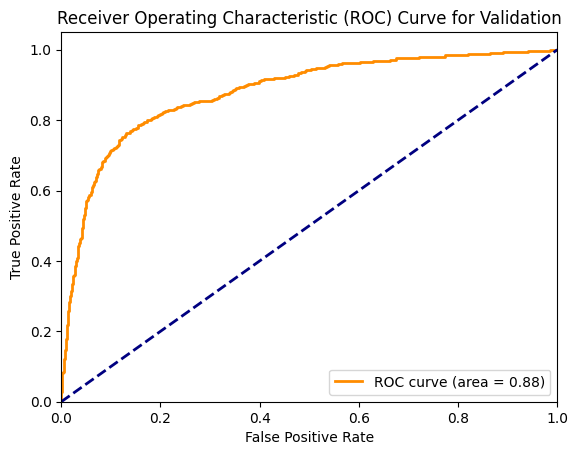

AUROC for Validation: 0.8799


In [3]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

#Завантажуємо дані
df = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/train.csv", index_col=0)

#Створюємо тренувальний та валідаційний датасети
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Exited'])

#Визначаємо набір незалежних змінних та таргет змінну
input_cols = list(train_df.columns)[2:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

#Виявляємо числові та категоріальні змінні
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
scaled_cols = train_inputs[numeric_cols].drop(columns=['HasCrCard', 'IsActiveMember']).columns.tolist()
label_cols = [categorical_cols[1]]
target_cols = [categorical_cols[0]]

#Створюємо кастомний label encoder (оскільки Scikit-learn LabelEncoder не підтримується у Pipeline)
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = LabelEncoder()
        self.encoder.fit(X)
        return self

    def transform(self, X):
        return self.encoder.transform(X).reshape(-1, 1)

#Створюємо пайплайни попередньої обробки для числових та категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

label_transformer = Pipeline(steps=[
    ('label', CustomLabelEncoder())
])

target_transformer = Pipeline(steps=[
    ('target', TargetEncoder())
])

#Додаємо трансформери в передобробку
preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat_label', label_transformer, label_cols),
    ('cat_target', target_transformer, target_cols)
])

#Створюємо пайплайн, що об'єднує попередню обробку та модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

#Тренуємо модель
model_pipeline.fit(train_inputs, train_targets)

#Допоміжна функція, що робить передбачення, розраховує accuracy та будує графік confusion matrix
def predict_f1_matrix(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    f1_score_ = f1_score(targets, preds)
    print(f"F1 score {name}: {f1_score_:.2f}%")

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

#Робимо передбачення на тренувальних та валідаційних даних
val_preds = predict_f1_matrix(train_inputs, train_targets, 'Train')
test_preds = predict_f1_matrix(val_inputs, val_targets, 'Validation')

#Допоміжна функція, що розраховує AUROC та будує графік ROC Curve
def compute_auroc_and_build_roc(inputs, targets, name=''):
  y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]

  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show();
  print(f'AUROC for {name}: {roc_auc:.4f}')

#Будуємо ROC Curve
compute_auroc_and_build_roc(train_inputs, train_targets, 'Train')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

#Зберігаємо натреновану модель
joblib.dump(model_pipeline, 'drive/MyDrive/ML_Course/Data/churn_prediction/churn_prediction_pipeline.joblib')

#Завантажуємо натреновану модель
model_pipeline_loaded = joblib.load('drive/MyDrive/ML_Course/Data/churn_prediction/churn_prediction_pipeline.joblib')

Натренована модель показує дуже схожий показник AU ROC, що свідчить про те, що вона непогано справляється з новими даними.

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Accuracy: 89.19%
F1 score Train: 0.69%
Accuracy: 88.73%
F1 score Validation: 0.69%


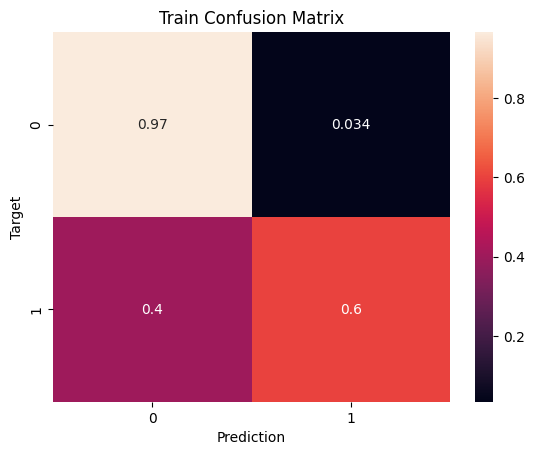

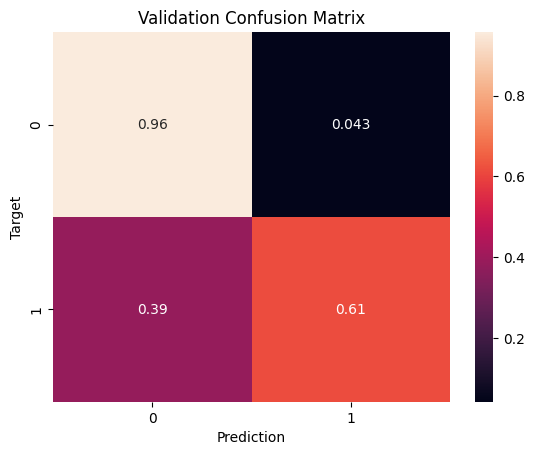

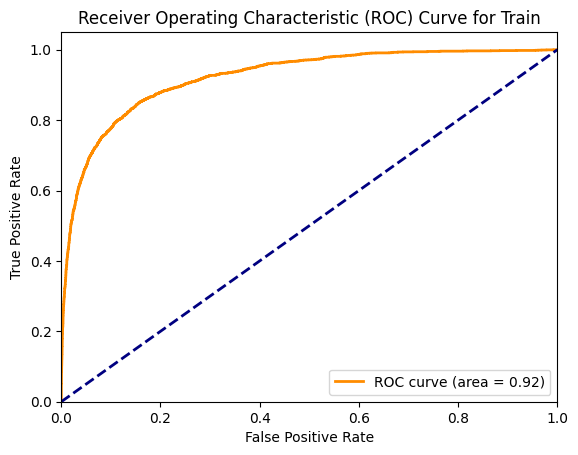

AUROC for Train: 0.9218


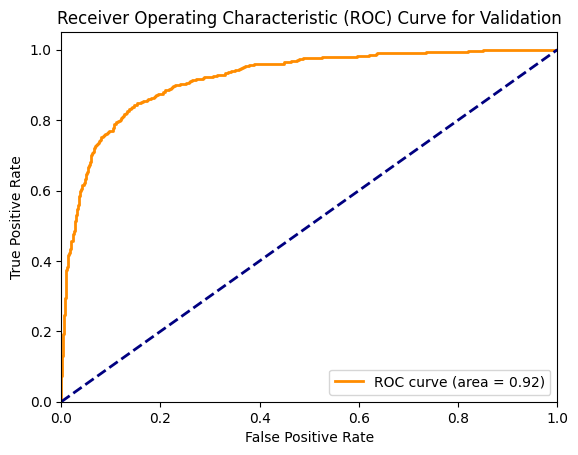

AUROC for Validation: 0.9193


In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poli', PolynomialFeatures(degree=2))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat_label', label_transformer, label_cols),
    ('cat_target', target_transformer, target_cols)
])

#Створюємо пайплайн, що об'єднує попередню обробку та модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

#Тренуємо модель
model_pipeline.fit(train_inputs, train_targets)

val_preds = predict_f1_matrix(train_inputs, train_targets, 'Train')
test_preds = predict_f1_matrix(val_inputs, val_targets, 'Validation')

compute_auroc_and_build_roc(train_inputs, train_targets, 'Train')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

Отримана модель з поліномом 2 доволі непогано генералізує дані, оскільки немає суттєвої різниці між показником AUROC. Також, бачимо покращення цих показників як для трейн так і для валідаційного сетів в порівнянні з попередньою моделлю.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Accuracy: 90.28%
F1 score Train: 0.74%
Accuracy: 89.50%
F1 score Validation: 0.72%


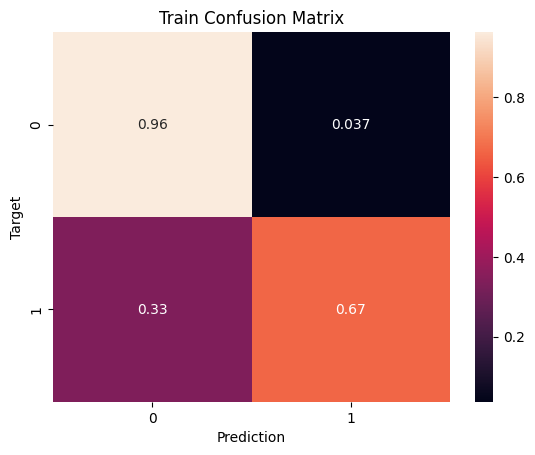

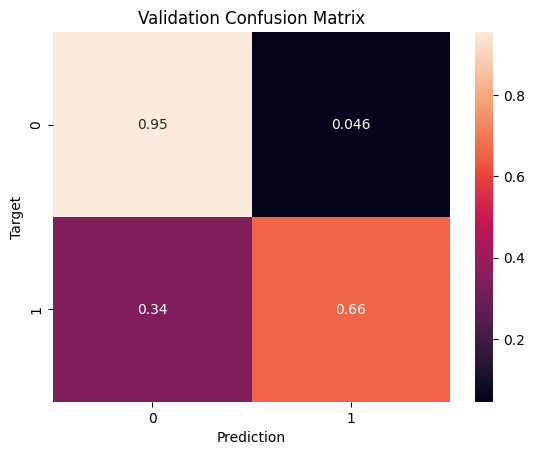

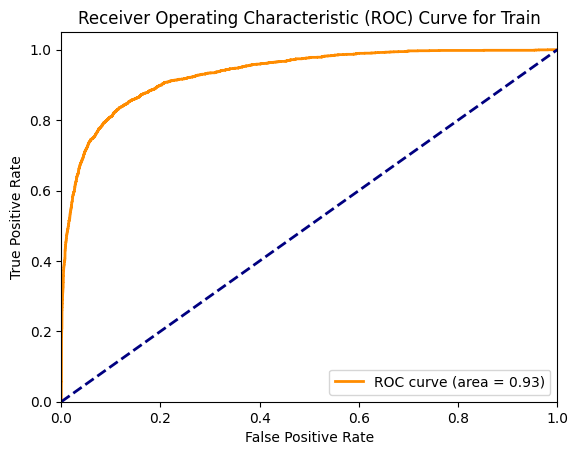

AUROC for Train: 0.9330


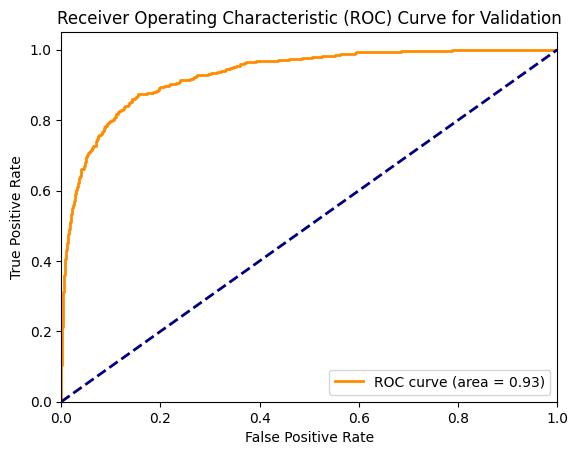

AUROC for Validation: 0.9301


In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poli', PolynomialFeatures(degree=4))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat_label', label_transformer, label_cols),
    ('cat_target', target_transformer, target_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline.fit(train_inputs, train_targets)

val_preds = predict_f1_matrix(train_inputs, train_targets, 'Train')
test_preds = predict_f1_matrix(val_inputs, val_targets, 'Validation')

compute_auroc_and_build_roc(train_inputs, train_targets, 'Train')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

Збільшення поліному до 4 не призвело до перенавчання моделі, оскільки на валідаційних даних вона все ще дає дуже високий показник AUROC, який не суттєво відрізняється від аналогічного показника для тренувальних даних.

In [6]:
test_raw_df = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/test.csv", index_col=0)
sample_submission = pd.read_csv("drive/MyDrive/ML_Course/Data/churn_prediction/sample_submission.csv", index_col=0)

In [7]:
preds = model_pipeline.predict(test_raw_df)

In [8]:
prob_test = model_pipeline.predict_proba(test_raw_df)[:,1]

In [9]:
sample_submission['Exited'] = prob_test

In [10]:
sample_submission.head(5)

,Exited
id,
15000,0.071729
15001,0.020411
15002,0.070651
15003,0.394660
15004,0.025214


In [11]:
sample_submission.reset_index().to_csv("drive/MyDrive/ML_Course/Data/churn_prediction/submission_log_reg_4_degree.csv", index=False)

Для експерименту, змінимо в моделі параметри регуляризації.

Accuracy: 90.38%
F1 score Train: 0.74%
Accuracy: 89.73%
F1 score Validation: 0.73%


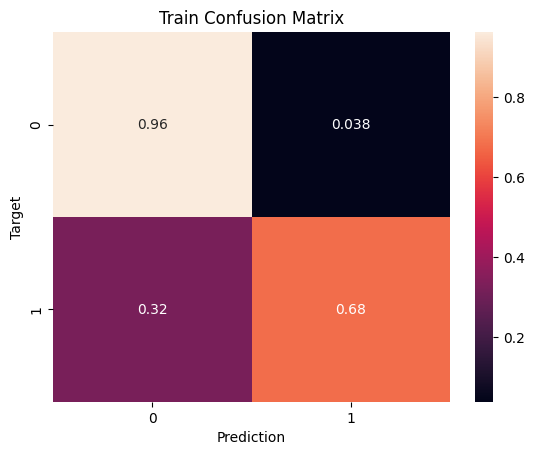

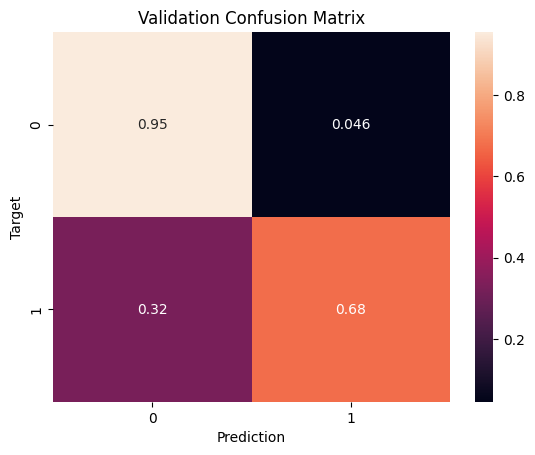

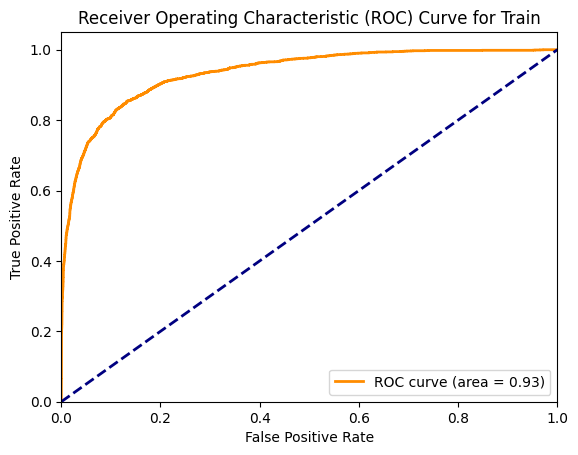

AUROC for Train: 0.9346


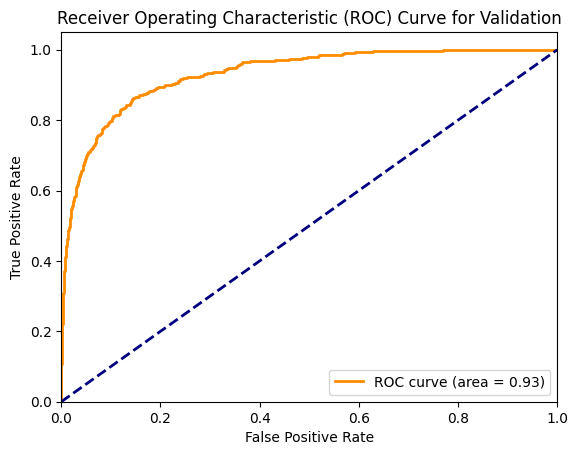

AUROC for Validation: 0.9313


In [12]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poli', PolynomialFeatures(degree=4))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat_label', label_transformer, label_cols),
    ('cat_target', target_transformer, target_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l2', C=2))
])

model_pipeline.fit(train_inputs, train_targets)

val_preds = predict_f1_matrix(train_inputs, train_targets, 'Train')
test_preds = predict_f1_matrix(val_inputs, val_targets, 'Validation')

compute_auroc_and_build_roc(train_inputs, train_targets, 'Train')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

Результати моделі ще покращились в порівнянні з попереднім варіантом

In [13]:
prob_test = model_pipeline.predict_proba(test_raw_df)[:,1]

In [14]:
sample_submission['Exited'] = prob_test

In [15]:
sample_submission.head(5)

,Exited
id,
15000,0.069208
15001,0.017998
15002,0.064386
15003,0.407558
15004,0.024273


In [16]:
sample_submission.reset_index().to_csv("drive/MyDrive/ML_Course/Data/churn_prediction/submission_log_reg_4_degree_l2_2.csv", index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

regression_df = pd.read_csv("drive/MyDrive/ML_Course/Data/regression_data.csv")

train_regression_df, val_regression_df = train_test_split(regression_df, test_size=0.2, random_state=42)
input_cols = list(regression_df.columns)[:-1]
target_col = list(regression_df.columns)[-1]
train_inputs = train_regression_df[input_cols]
train_targets = train_regression_df[target_col]
val_inputs = val_regression_df[input_cols]
val_targets = val_regression_df[target_col]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poli', PolynomialFeatures(degree=5))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, input_cols),
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

model_pipeline.fit(train_inputs, train_targets)

train_pred = model_pipeline.predict(train_inputs)
val_pred = model_pipeline.predict(val_inputs)

rmse_train = root_mean_squared_error(train_targets, train_pred)
rmse_val = root_mean_squared_error(val_targets, val_pred)

print(f"Train RMSE for Linear Regression: {rmse_train:.3f}")
print(f"Val RMSE for Linear Regression: {rmse_val:.3f}\n")

Train RMSE for Linear Regression: 0.000
Val RMSE for Linear Regression: 35.628



Натренована модель демонструє ознаки перенавчання, оскільки при відсутності помилок на тренувальному сеті, вона показує велику помилку на валідаційному.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [18]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Ridge(),
    Lasso(),
    ElasticNet()
]

In [19]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poli', PolynomialFeatures(degree=20))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, input_cols),
])

for model in models:
  model_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', model)
  ])

  model_pipeline.fit(train_inputs, train_targets)

  train_pred = model_pipeline.predict(train_inputs)
  val_pred = model_pipeline.predict(val_inputs)

  rmse_train = root_mean_squared_error(train_targets, train_pred)
  rmse_val = root_mean_squared_error(val_targets, val_pred)

  print(f"For {str(model)}\nTrain RMSE: {rmse_train:.3f}\nVal RMSE: {rmse_val:.3f}\n")


For Ridge()
Train RMSE: 30.879
Val RMSE: 152443.032

For Lasso()
Train RMSE: 2.198
Val RMSE: 14.945

For ElasticNet()
Train RMSE: 9.148
Val RMSE: 241.664



Найкраще генералізує дані модель, натренована з Lasso(): найнижче значення RMSE на тренувальних даних і на валідаційних даних. Проте, варто відмітити, що різниця між значеннями RMSE для тренувального та валідаційного сетів свідчить про перенавчання моделі.  
Припускаю, що кращий результат саме цієї моделі, в порівнянні з іншими, пов'язаний з тим, що Lasso автоматично виконує відбір ознак, що зменшує ризик перенавчання. Це могло підвищити якість прогнозів завдяки видаленню менш важливих фіч.  
Для обгрунтування цього припущення, побудуємо графік кореляції на вхідному датасеті

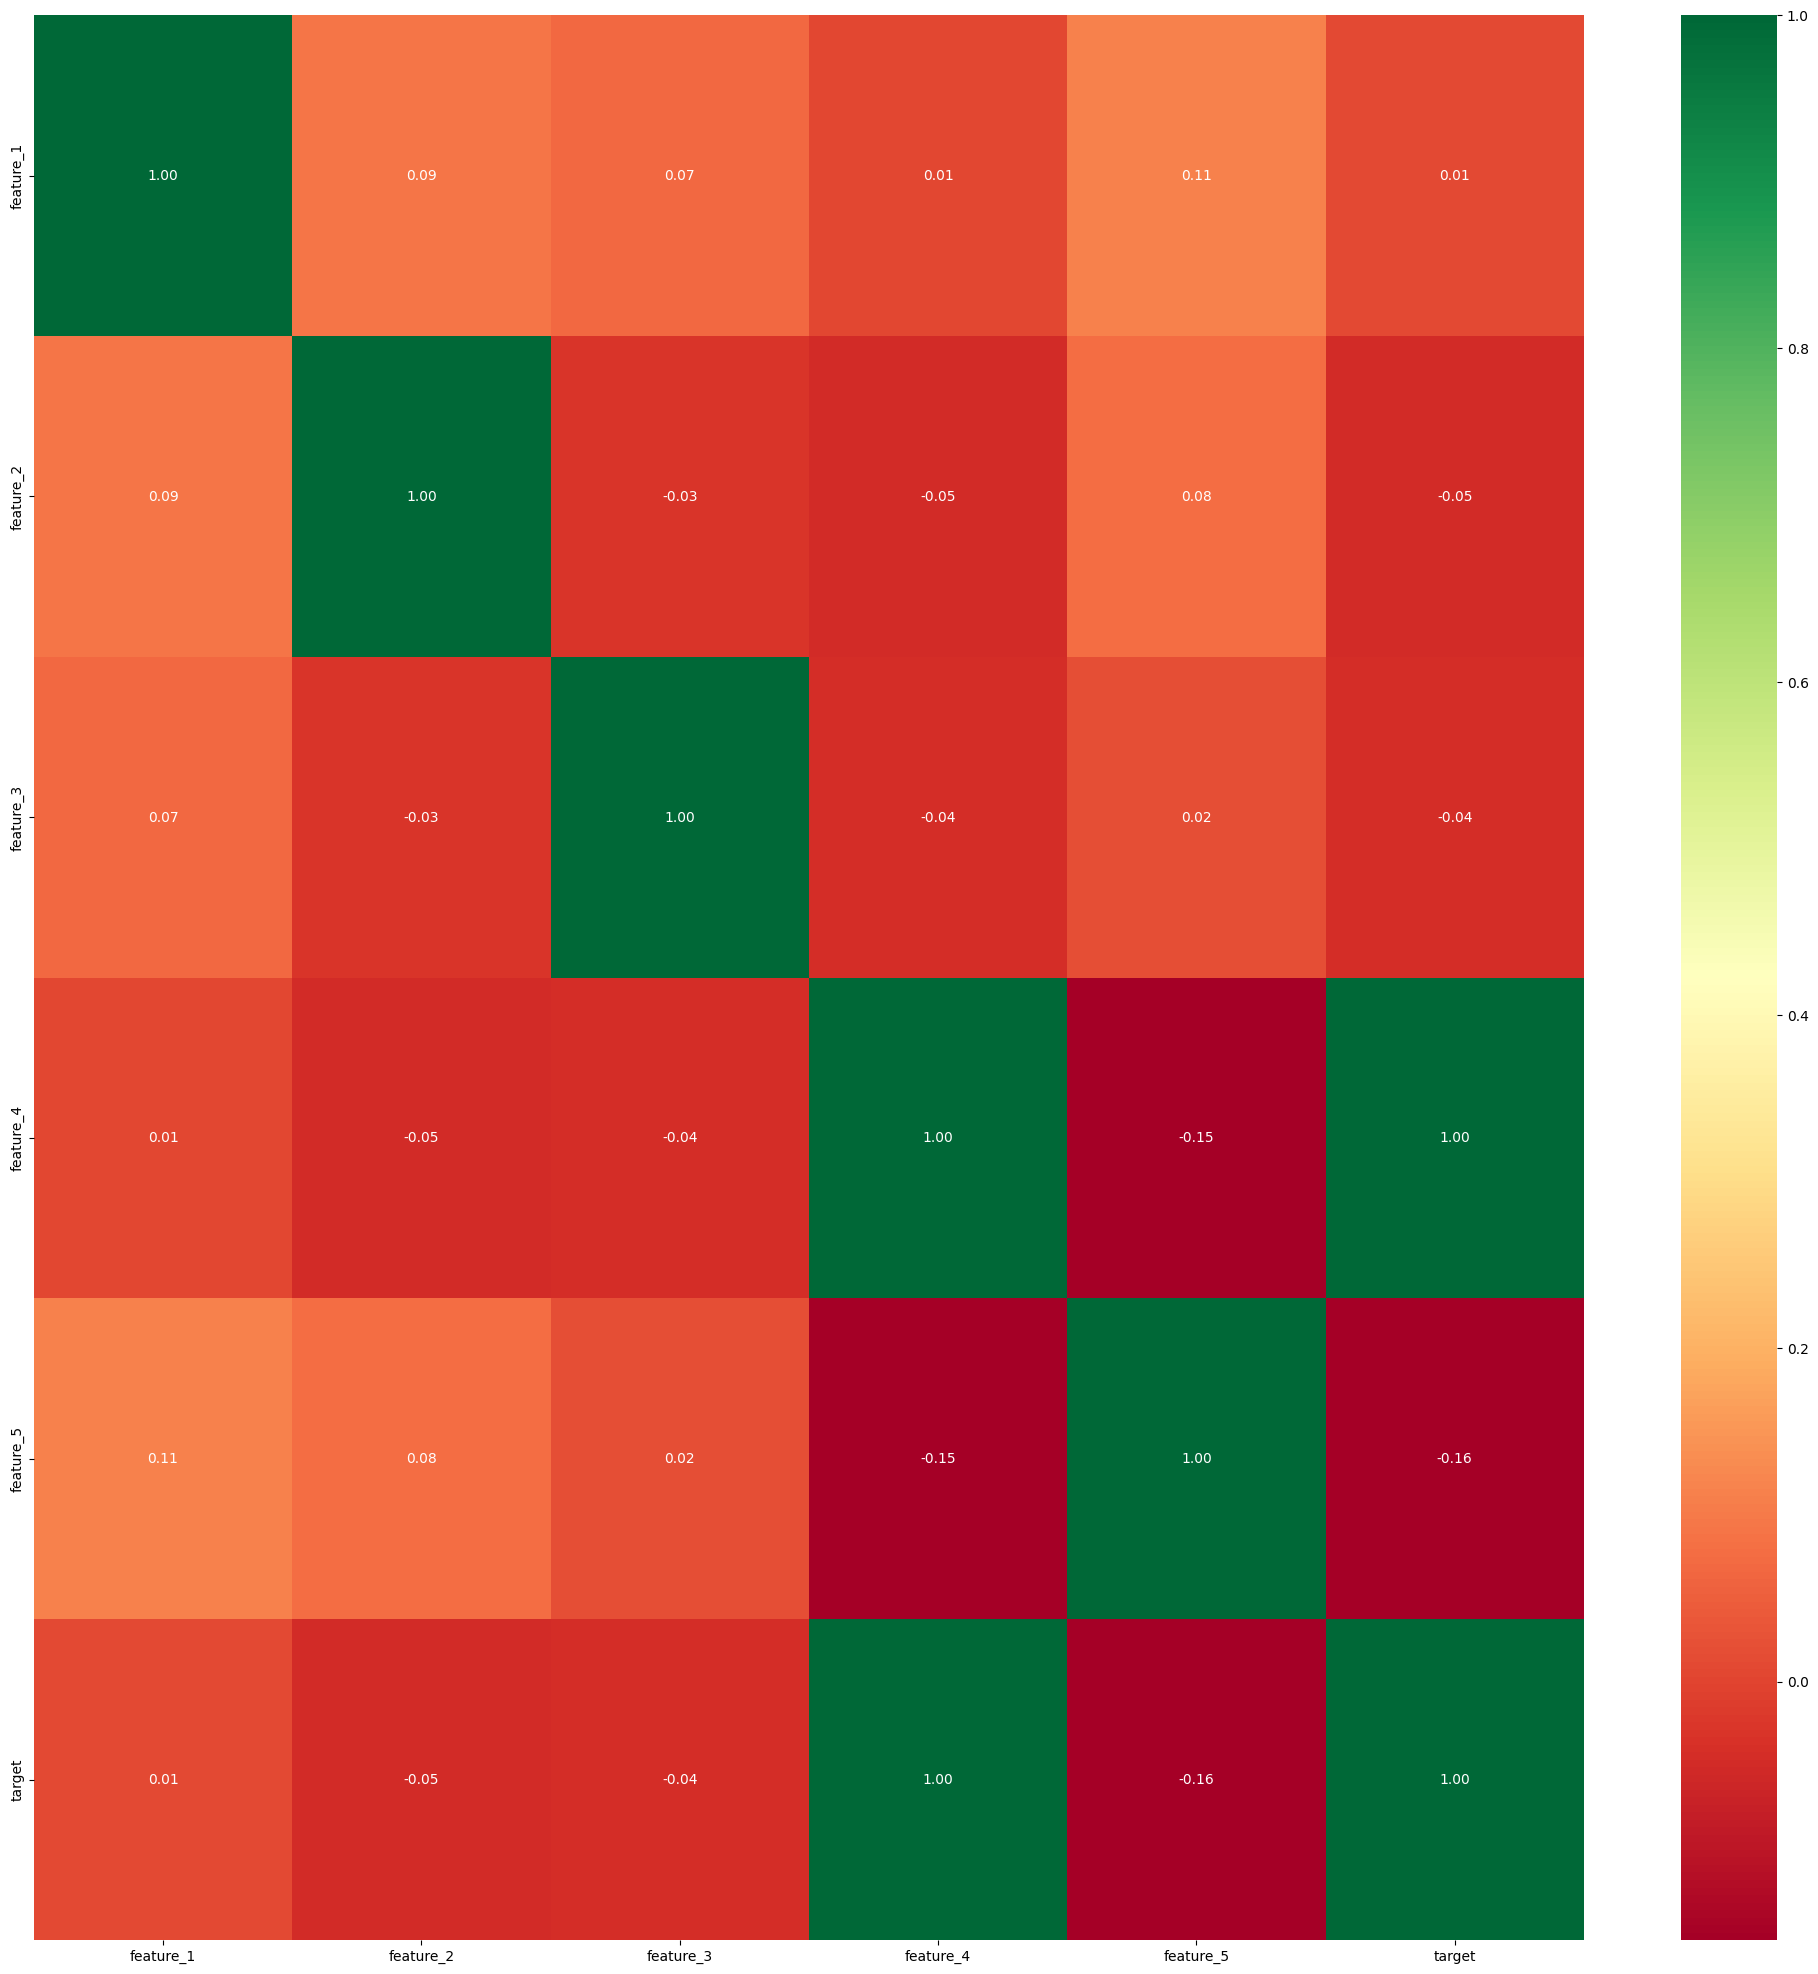

In [20]:
corr_df = regression_df.corr()
plt.figure(figsize = (25,25))
sns.heatmap(data = corr_df, annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()

Як можна побачити, що лише одна фіча (feature_4) має кореляцію 1.0, що може означати, що вона повністю визначає таргет (або є його дубльованою версією). Ще одна фіча (feature_5) з кореляцією 0.15 має слабкий зв’язок із таргетом. Решта фіч майже не впливають на таргет у лінійному контексті.  
Це підтверджує, що Lasso правильно зануляє неважливі фічі.  
Ми можемо це перевірити додатково.

In [21]:
np.mean(model_pipeline.named_steps['classifier'].coef_ < 0.00000001)

0.8839262187088274

Отже, 88% мають коефіціенти близькі до 0.

В якості експерименту, зменшимо параметр, що відповідає за максимальну кількість ітерацій навчання моделі, щоб оцінити вплив цього параметра на результати

In [22]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poli', PolynomialFeatures(degree=20))
])

preprocessor = ColumnTransformer(
  transformers=[
    ('num', numeric_transformer, input_cols),
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Lasso(max_iter=500))
])

model_pipeline.fit(train_inputs, train_targets)

train_pred = model_pipeline.predict(train_inputs)
val_pred = model_pipeline.predict(val_inputs)

rmse_train = root_mean_squared_error(train_targets, train_pred)
rmse_val = root_mean_squared_error(val_targets, val_pred)

print(f"Train RMSE for Linear Regression: {rmse_train:.3f}")
print(f"Val RMSE for Linear Regression: {rmse_val:.3f}\n")

Train RMSE for Linear Regression: 2.152
Val RMSE for Linear Regression: 6.548



In [23]:
np.mean(model_pipeline.named_steps['classifier'].coef_ < 0.00000001)

0.9448146056841709

Отже, бачимо, що зменшення ітерацій під час градієнтного спуску, в нашому випадку значно покращило результати. Модель жорсткіше штрафувала фічі, залишаючи тільки ті, що дійсно мають вплив.